In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

load dataset 

In [128]:
demand = pd.read_csv("demand_sales_data.csv")

Preview the dataset¶

In [129]:
demand.head()


,date,Order_ID,Company,Company_Region,Product_ID,Product,Customer_ID,Product Category01,Product Category02,Product Category03,Quantity,unit,price_per_case
0,1/1/2021,6141309,121,South,11829,AVO32CNV2,DMKUT,32.0000,CNV,#2,224,case,41.0000
1,1/1/2021,6377268,131,North,11541,AVO60CNV1,QPDXK,60.0000,CNV,1,396,case,46.0000
2,1/1/2021,6377268,131,North,11931,AVO48CNV1,QPDXK,NaN,CNV,1,148,case,45.0000
3,1/1/2021,6191867,121,South,11829,AVO32CNV2,IEHDJ,32.0000,CNV,#2,150,case,41.0000
4,1/1/2021,6191867,121,South,11385,AVO48CNV2,IEHDJ,48.0000,CNV,#2,294,case,49.0000


Check shape of the dataset¶

In [130]:
demand.shape

(11386, 13)

View summary of dataset¶


In [131]:
demand.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11386 entries, 0 to 11385
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                11386 non-null  object 
 1   Order_ID            11386 non-null  int64  
 2   Company             11386 non-null  int64  
 3   Company_Region      11386 non-null  object 
 4   Product_ID          11386 non-null  int64  
 5   Product             11240 non-null  object 
 6   Customer_ID         11386 non-null  object 
 7   Product Category01  11148 non-null  float64
 8   Product Category02  11138 non-null  object 
 9   Product Category03  11264 non-null  object 
 10  Quantity            11386 non-null  int64  
 11  unit                11386 non-null  object 
 12  price_per_case      11386 non-null  float64
dtypes: float64(2), int64(4), object(7)
memory usage: 1.1+ MB


View the statistical summary of numerical variables¶


In [ ]:
demand.describe()

,Order_ID,Company,Product_ID,Product Category01,Quantity,price_per_case
count,11386.0000,11386.0000,11386.0000,11148.0000,11386.0000,11386.0000
mean,6549631.1096,125.9737,11672.4488,44.6211,312.8847,42.5271
std,261090.9832,5.0002,249.6518,13.4758,508.3881,4.6549
min,6100387.0000,121.0000,11133.0000,32.0000,10.0000,35.0000
25%,6320594.0000,121.0000,11501.0000,32.0000,114.0000,38.0000
50%,6559179.0000,121.0000,11829.0000,48.0000,227.0000,42.0000
75%,6775274.0000,131.0000,11829.0000,48.0000,344.0000,47.0000
max,6999432.0000,131.0000,11931.0000,600.0000,10407.0000,50.0000


Check for missing values in dataset¶

In [133]:
demand.isnull().sum()

date                    0
Order_ID                0
Company                 0
Company_Region          0
Product_ID              0
Product               146
Customer_ID             0
Product Category01    238
Product Category02    248
Product Category03    122
Quantity                0
unit                    0
price_per_case          0
dtype: int64

In [134]:
demand.columns=demand.columns.str.lower()
print(list(demand.columns))

['date', 'order_id', 'company', 'company_region', 'product_id', 'product', 'customer_id', 'product category01', 'product category02', 'product category03', 'quantity', 'unit', 'price_per_case']


In [135]:
demand['product'] = demand['product'].fillna(demand['product'].mode()[0])

Drop  columns


In [136]:
demand=demand.drop(['product category01'],axis=1)
demand=demand.drop(['product category02'],axis=1)
demand=demand.drop(['product category03'],axis=1)

“Extract relevant features (Size, Type, Grade) from the Product column.”

In [137]:
demand['size'] = demand['product'].str.extract(r'AVO(\d+)')
demand['type_product'] = demand['product'].str.extract(r'(CNV|ORG)')
demand['grade_product'] = demand['product'].str.extract(r'(\d)$')

 Convert all quantities from kg to case

In [138]:
unit_conversion = {'kg': 1/11.3, 'case': 1}

demand['quantity'] = demand['quantity'] * demand['unit'].map(unit_conversion)

demand['unit'] = 'case'

Feature Engineering

In [ ]:
demand['date']=pd.to_datetime(demand['date'])

# extract year from 'Date' column
demand['year'] = demand['date'].dt.year

# extract month from 'Date' column
demand['month'] = demand['date'].dt.month

# extract day from 'Date' column
demand['weekday'] = demand['date'].dt.dayofweek

# Extract the week number in the year
demand['week'] = demand['date'].dt.isocalendar().week

demand.sort_values('date', inplace=True)

In [2]:
a = {'size48_12' : 10 , 'size_48_13':15}

a['size48_12']

10

Exploratory Analysis

In [140]:
annual_quantity = demand.groupby('year')['quantity'].sum().reset_index()
fig = px.line(annual_quantity, x='year', y='quantity', 
              markers=True,
              title='Quantity Trend per Year',
              labels={'quantity':'Total Quantity', 'year':'Year'})

fig.show()



fig1 = px.bar(demand.groupby('company_region', as_index=False)['quantity'].sum(),
              x='company_region', y='quantity',
              title='Total Quantity Sold by Region',
              color='company_region')
fig1.show()


annual_quantity = demand.groupby('year')['quantity'].sum().reset_index()

fig = px.bar(annual_quantity, x='year', y='quantity',
             title='Total Quantity per Year',
             labels={'quantity':'Total Quantity', 'year':'Year'},
             text='quantity')

fig.update_traces(texttemplate='%{text:.0f}', textposition='outside')
fig.show()

demand['year'] = demand['date'].dt.year
demand['week'] = demand['date'].dt.isocalendar().week.astype(int)

weekly_quantity = demand.groupby(['year', 'week'])['quantity'].sum().reset_index()

import plotly.express as px

fig = px.line(
    weekly_quantity,
    x='week',
    y='quantity',
    color='year',        
    markers=True,
    title='Quantity Trend per Week by Year',
    labels={'quantity':'Total Quantity', 'week':'Week', 'year':'Year'}
)

fig.show()








fig.show()

monthly_quantity = demand.groupby(['year', 'month'], as_index=False)['quantity'].sum()

fig = px.line(monthly_quantity, x='month', y='quantity',
              color='year', markers=True,
              title='Total Monthly Quantity per Year')

fig.show()



monthly_price = demand.groupby(['year', 'month'], as_index=False)['price_per_case'].mean()
fig4 = px.line(monthly_price, x='month', y='price_per_case',
               color='year', markers=True,
               title='Average Monthly Price per Case')
fig4.show()

fig2 = px.bar(demand.groupby('size', as_index=False)['quantity'].sum(),
              x='size', y='quantity', title='Total Quantity by Size',
              color='size')
fig2.show()






fig7 = px.bar(demand.groupby('weekday', as_index=False)['quantity'].sum(),
              x='weekday', y='quantity',
              title='Total Quantity Sold by Weekday',
              color='weekday')
fig7.show()

fig = px.pie(demand, names='type_product', 
             title='Proportion of Type_Product')

fig.show()


demand['year'] = demand['date'].dt.year
demand['week'] = demand['date'].dt.isocalendar().week.astype(int)

weekly_quantity = demand.groupby(['year', 'week'])['quantity'].sum().reset_index()




demand['total_sales'] = demand['quantity'] * demand['price_per_case']
annual_sales = demand.groupby(['company', 'year'])['total_sales'].sum().reset_index()
fig = px.line(
    annual_sales,
    x='year',
    y='total_sales',
    color='company',
    markers=True,
    title='Annual Company Sales',
    labels={'total_sales':'Total Sales', 'year':'Year', 'company':'Company'}
)
fig.show()


customer_sales = demand.groupby('customer_id')['quantity'].sum().reset_index()
customer_sales = customer_sales.sort_values('quantity', ascending=False)

fig = px.bar(
    customer_sales.head(20),
    x='customer_id',
    y='quantity',
    title='Top 20 Customers by Quantity Purchased',
    labels={'customer_id':'Customer ID', 'quantity':'Total Quantity Purchased'},
    text='quantity'
)

fig.update_traces(textposition='outside')
fig.show()



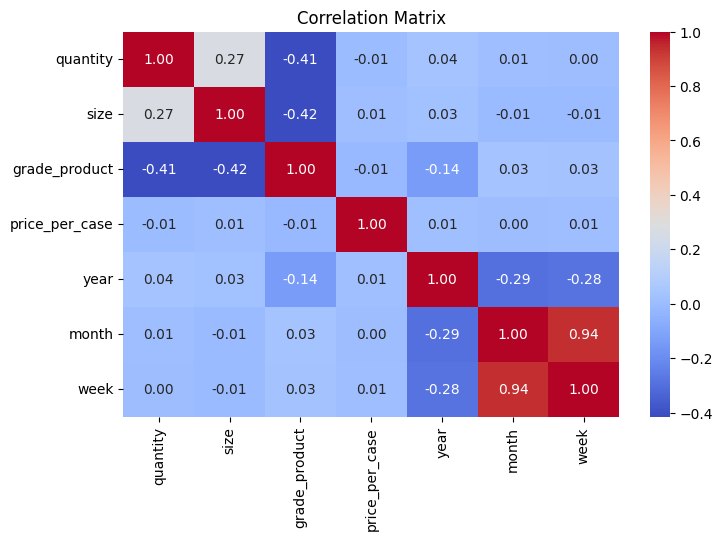

In [141]:
demand['grade_product'] = pd.to_numeric(demand['grade_product'], errors='coerce')
demand['size'] = pd.to_numeric(demand['size'], errors='coerce')


corr = demand[['quantity','size','grade_product', 'price_per_case', 'year', 'month', 'week']].corr()
plt.figure(figsize=(8,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Feature Selection
###### embeded method

In [142]:
features = ['quantity', 'size', 'grade_product', 'year', 'month', 'week']
F = demand[features]
T = demand['price_per_case']

selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(F, T)

feature_scores = pd.DataFrame({
    'Feature': F.columns,
    'Score': selector.scores_
})

print(feature_scores.sort_values(by='Score', ascending=False))

         Feature  Score
2  grade_product 1.9173
3           year 1.7232
5           week 0.9893
1           size 0.3528
0       quantity 0.2926
4          month 0.2730


In [143]:
demand.tail()

,date,order_id,company,company_region,product_id,product,customer_id,quantity,unit,price_per_case,size,type_product,grade_product,year,month,weekday,week,total_sales
11376,2023-08-20,6690038,131,North,11829,AVO32CNV2,QPDXK,30.0000,case,38.0000,32,CNV,2,2023,8,6,33,1140.0000
11375,2023-08-20,6271650,131,North,11541,AVO60CNV1,DWCGE,146.0000,case,50.0000,60,CNV,1,2023,8,6,33,7300.0000
11374,2023-08-20,6271650,131,North,11931,AVO48CNV1,DWCGE,270.0000,case,50.0000,48,CNV,1,2023,8,6,33,13500.0000
11378,2023-08-20,6690038,131,North,11541,AVO60CNV1,QPDXK,675.0000,case,50.0000,60,CNV,1,2023,8,6,33,33750.0000
11385,2023-08-20,6271650,131,North,11501,AVO32CNV1,DWCGE,300.0000,case,46.0000,32,CNV,1,2023,8,6,33,13800.0000


In [144]:
weekly_data_by_size = {}
df = pd.DataFrame()

for size in demand['size'].unique():
    size_data = demand[demand['size'] == size].copy()
    
    size_data = size_data.sort_values('date')
    size_data.set_index('date', inplace=True)
    
    weekly_summary = size_data.resample('W').agg({
        'quantity': 'sum',
        'price_per_case': 'mean'
    }).reset_index()
    
    weekly_summary['year'] = weekly_summary['date'].dt.year
    weekly_summary['month'] = weekly_summary['date'].dt.month
    weekly_summary['weekday'] = weekly_summary['date'].dt.dayofweek
    weekly_summary['weekofyear'] = weekly_summary['date'].dt.isocalendar().week
    weekly_summary['quarter'] = weekly_summary['date'].dt.quarter

    for col in ['price_per_case', 'quantity']:
        weekly_summary[f'{col}_lag_4'] = weekly_summary[col].shift(4)
        weekly_summary[f'{col}_roll_mean'] = weekly_summary[col].shift(4).rolling(window=4).mean()
        weekly_summary[f'{col}_roll_std']  = weekly_summary[col].shift(4).rolling(window=4).std()
    
    weekly_summary.ffill(inplace=True)
    weekly_summary.bfill(inplace=True)


    weekly_summary['size'] = size
    
    weekly_data_by_size[size] = weekly_summary
    df = pd.concat([df, weekly_summary])

df.reset_index(drop=True, inplace=True)




In [154]:
weekly_summary

,date,quantity,price_per_case,year,month,weekday,weekofyear,quarter,price_per_case_lag_4,price_per_case_roll_mean,price_per_case_roll_std,quantity_lag_4,quantity_roll_mean,quantity_roll_std,size
0,2021-01-03,4273.0000,41.6000,2021,1,6,53,1,41.6000,41.6741,0.4296,4273.0000,7796.2500,2393.0376,48
1,2021-01-10,8913.0000,42.1364,2021,1,6,1,1,41.6000,41.6741,0.4296,4273.0000,7796.2500,2393.0376,48
2,2021-01-17,8441.0000,41.1200,2021,1,6,2,1,41.6000,41.6741,0.4296,4273.0000,7796.2500,2393.0376,48
3,2021-01-24,9558.0000,41.8400,2021,1,6,3,1,41.6000,41.6741,0.4296,4273.0000,7796.2500,2393.0376,48
4,2021-01-31,9107.0000,42.8214,2021,1,6,4,1,41.6000,41.6741,0.4296,4273.0000,7796.2500,2393.0376,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,2023-07-23,9489.0000,45.0455,2023,7,6,29,3,43.1304,42.6017,1.0469,9784.0000,9794.9978,357.2403,48
134,2023-07-30,9763.0000,44.0370,2023,7,6,30,3,42.7308,42.7576,0.9938,10248.0000,10013.7478,269.9288,48
135,2023-08-06,9362.9558,44.1579,2023,8,6,31,3,41.5833,42.8011,0.9158,9827.0000,10026.4978,255.7897,48
136,2023-08-13,8878.0000,41.2500,2023,8,6,32,3,43.7391,42.7959,0.9085,9992.0000,9962.7500,210.2401,48


In [145]:
df.groupby('size').tail(4)


,date,quantity,price_per_case,year,month,weekday,weekofyear,quarter,price_per_case_lag_4,price_per_case_roll_mean,price_per_case_roll_std,quantity_lag_4,quantity_roll_mean,quantity_roll_std,size
134,2023-07-30,6302.0000,41.8788,2023,7,6,30,3,39.7143,42.1394,1.6521,6896.0000,5995.2168,612.0402,32
135,2023-08-06,5070.0000,43.0870,2023,8,6,31,3,43.4667,42.2388,1.7365,5872.9115,6008.7058,607.4379,32
136,2023-08-13,5406.0000,42.5000,2023,8,6,32,3,42.8788,42.3375,1.7661,6136.9027,6158.9535,519.4693,32
137,2023-08-20,8601.0000,41.0312,2023,8,6,33,3,42.7500,42.2024,1.6878,5916.0000,6205.4535,474.6652,32
272,2023-07-30,6676.0000,41.4737,2023,7,6,30,3,38.1250,41.7218,2.6941,5870.0000,6354.2301,646.8437,60
273,2023-08-06,5852.9558,43.1429,2023,8,6,31,3,42.8000,42.0534,2.7347,5514.9115,5982.9735,574.8656,60
274,2023-08-13,6429.0000,40.5625,2023,8,6,32,3,44.4375,42.0438,2.7233,5807.9292,5730.7102,154.8483,60
275,2023-08-20,6334.0000,43.8824,2023,8,6,33,3,42.5000,41.9656,2.6983,5628.0000,5705.2102,163.1787,60
410,2023-07-30,9763.0000,44.0370,2023,7,6,30,3,42.7308,42.7576,0.9938,10248.0000,10013.7478,269.9288,48
411,2023-08-06,9362.9558,44.1579,2023,8,6,31,3,41.5833,42.8011,0.9158,9827.0000,10026.4978,255.7897,48


Data Modeling

In [146]:
results_by_size = {}

for size, df_size in weekly_data_by_size.items():
    print(f"Training for size: {size}")
    
    df_size = df_size.sort_index()
    
    df_size['week_sin'] = np.sin(2 * np.pi * df_size['weekofyear'] / 52)
    df_size['week_cos'] = np.cos(2 * np.pi * df_size['weekofyear'] / 52)
    df_size['month_sin'] = np.sin(2 * np.pi * df_size['month'] / 12)
    df_size['month_cos'] = np.cos(2 * np.pi * df_size['month'] / 12)
    
    n_splits = 5
    fold_sizes = len(df_size) // n_splits
    fold = 0
    preds = []
    y_test_list = []
    scores = []

    for i in range(1, n_splits + 1):
        train_end = i * fold_sizes
        train = df_size.iloc[:train_end]
        test = df_size.iloc[train_end:train_end + fold_sizes]

        if len(test) == 0:
            break  

        FEATURES = [
            'year', 'month', 'weekday', 'weekofyear', 'quarter',
            'price_per_case_lag_4', 'price_per_case_roll_mean', 'price_per_case_roll_std',
            'quantity_lag_4', 'quantity_roll_mean', 'quantity_roll_std',
            'week_sin', 'week_cos', 'month_sin', 'month_cos', 'size'
        ]
        TARGET = 'price_per_case'

        X_train = train[FEATURES]
        y_train = train[TARGET]
        X_test = test[FEATURES]
        y_test = test[TARGET]

        if size == 32:
            reg = xgb.XGBRegressor(
                n_estimators=1000,
                max_depth=5,
                learning_rate=0.05,
                objective='reg:squarederror',
                early_stopping_rounds=50
            )
            reg.fit(
                X_train, y_train,
                eval_set=[(X_train, y_train), (X_test, y_test)],
                verbose=100
            )
        else:
            reg = RandomForestRegressor(
                n_estimators=800,
                max_depth=None,
                min_samples_leaf=5,
                random_state=42
            )
            reg.fit(X_train, y_train)

        y_pred = reg.predict(X_test)
        preds.append(y_pred)
        y_test_list.append(y_test.values)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        scores.append(rmse)
        print(f"  Fold {fold} RMSE: {rmse}")
        fold += 1

    avg_rmse = np.mean(scores)
    print(f"Average RMSE for size {size}: {avg_rmse}\n")

    results_by_size[size] = {
        'model': reg,
        'preds': preds,
        'y_test_list': y_test_list,
        'scores': scores,
        'avg_rmse': avg_rmse
    }

#Evaluation

metrics_list = []

for size, res in results_by_size.items():
    y_true = np.concatenate(res['y_test_list'])
    y_pred = np.concatenate(res['preds'])
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred)/y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    
    model_name = 'XGBoost' if size == 32 else 'RandomForest'
    
    metrics_list.append({
        'Size': size,
        'Model': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE (%)': mape,
        'R2': r2
    })

metrics_df = pd.DataFrame(metrics_list)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', '{:.4f}'.format)

metrics_df


Training for size: 32
[0]	validation_0-rmse:1.46438	validation_1-rmse:1.51498
[54]	validation_0-rmse:0.36967	validation_1-rmse:1.57636
  Fold 0 RMSE: 1.5002454552909374
[0]	validation_0-rmse:1.45903	validation_1-rmse:1.42426
[56]	validation_0-rmse:0.40719	validation_1-rmse:1.82475
  Fold 1 RMSE: 1.4030773883050653
[0]	validation_0-rmse:1.43316	validation_1-rmse:1.49286
[49]	validation_0-rmse:0.59754	validation_1-rmse:1.74499
  Fold 2 RMSE: 1.4928615012926287
[0]	validation_0-rmse:1.43519	validation_1-rmse:1.25748
[50]	validation_0-rmse:0.65394	validation_1-rmse:1.57393
  Fold 3 RMSE: 1.2574780089016098
[0]	validation_0-rmse:1.40634	validation_1-rmse:0.93246
[65]	validation_0-rmse:0.60691	validation_1-rmse:0.98538
  Fold 4 RMSE: 0.8884431215021087
Average RMSE for size 32: 1.30842109505847

Training for size: 60
  Fold 0 RMSE: 0.907720391790814
  Fold 1 RMSE: 1.4686110518592426
  Fold 2 RMSE: 1.876966297934912
  Fold 3 RMSE: 1.469892726332246
  Fold 4 RMSE: 1.1644956972159126
Average RM

,Size,Model,RMSE,MAE,MAPE (%),R2
0,32,XGBoost,1.4051,1.1163,2.6158,-0.0317
1,60,RandomForest,1.4643,1.1526,2.7050,0.0247
2,48,RandomForest,1.4899,1.1853,2.7779,-0.0657


In [147]:

from plotly.subplots import make_subplots


n_sizes = len(weekly_data_by_size)
fig = make_subplots(
    rows=n_sizes, cols=1,
    shared_xaxes=True,
    subplot_titles=[f"Size {size}" for size in weekly_data_by_size.keys()]
)

row = 1
for size, df_size in weekly_data_by_size.items():
    df_size = df_size.sort_index()
    tss = TimeSeriesSplit(n_splits=5, test_size=12)
    fold = 0

    for train_idx, val_idx in tss.split(df_size):
        train = df_size.iloc[train_idx]
        test = df_size.iloc[val_idx]
        
        fig.add_trace(
            go.Scatter(
                x=train.index, y=train['price_per_case'],
                mode='lines',
                name=f'Size {size} - Train Fold {fold}',
                line=dict(color='royalblue'),
                opacity=0.6,
                showlegend=(row == 1)
            ),
            row=row, col=1
        )
        
        fig.add_trace(
            go.Scatter(
                x=test.index, y=test['price_per_case'],
                mode='lines',
                name=f'Size {size} - Test Fold {fold}',
                line=dict(color='orange', dash='dot', width=3),
                showlegend=(row == 1)
            ),
            row=row, col=1
        )
        
        fig.add_vline(
            x=test.index.min(),
            line=dict(color='gray', dash='dash'),
            row=row, col=1
        )
        
        fold += 1
    
    row += 1

fig.update_layout(
    height=300 * n_sizes,
    title_text="Time Series Split Visualization for All Sizes",
    template="plotly_dark",
    hovermode="x unified",
    legend=dict(x=0.02, y=1.02, orientation='h')
)

fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Price per Case")

fig.show()



import plotly.express as px

metrics_melted = metrics_df.melt(id_vars=['Size','Model'], 
                                 value_vars=['RMSE','MAE','MAPE (%)','R2'],
                                 var_name='Metric', value_name='Value')

fig = px.line(metrics_melted, 
              x='Metric', y='Value', color='Model', markers=True,
              facet_col='Size', facet_col_wrap=2,
              title='Model Evaluation Metrics by Size')

fig.update_layout(height=500, width=900)
fig.show()




In [148]:
df.groupby('size').tail(4)


,date,quantity,price_per_case,year,month,weekday,weekofyear,quarter,price_per_case_lag_4,price_per_case_roll_mean,price_per_case_roll_std,quantity_lag_4,quantity_roll_mean,quantity_roll_std,size
134,2023-07-30,6302.0000,41.8788,2023,7,6,30,3,39.7143,42.1394,1.6521,6896.0000,5995.2168,612.0402,32
135,2023-08-06,5070.0000,43.0870,2023,8,6,31,3,43.4667,42.2388,1.7365,5872.9115,6008.7058,607.4379,32
136,2023-08-13,5406.0000,42.5000,2023,8,6,32,3,42.8788,42.3375,1.7661,6136.9027,6158.9535,519.4693,32
137,2023-08-20,8601.0000,41.0312,2023,8,6,33,3,42.7500,42.2024,1.6878,5916.0000,6205.4535,474.6652,32
272,2023-07-30,6676.0000,41.4737,2023,7,6,30,3,38.1250,41.7218,2.6941,5870.0000,6354.2301,646.8437,60
273,2023-08-06,5852.9558,43.1429,2023,8,6,31,3,42.8000,42.0534,2.7347,5514.9115,5982.9735,574.8656,60
274,2023-08-13,6429.0000,40.5625,2023,8,6,32,3,44.4375,42.0438,2.7233,5807.9292,5730.7102,154.8483,60
275,2023-08-20,6334.0000,43.8824,2023,8,6,33,3,42.5000,41.9656,2.6983,5628.0000,5705.2102,163.1787,60
410,2023-07-30,9763.0000,44.0370,2023,7,6,30,3,42.7308,42.7576,0.9938,10248.0000,10013.7478,269.9288,48
411,2023-08-06,9362.9558,44.1579,2023,8,6,31,3,41.5833,42.8011,0.9158,9827.0000,10026.4978,255.7897,48


In [158]:
df

,date,quantity,price_per_case,year,month,weekday,weekofyear,quarter,price_per_case_lag_4,price_per_case_roll_mean,price_per_case_roll_std,quantity_lag_4,quantity_roll_mean,quantity_roll_std,size
0,2021-01-03,1976.0000,42.7500,2021,1,6,53,1,42.7500,42.3648,0.9097,1976.0000,3607.7500,1266.9929,32
1,2021-01-10,4030.0000,43.3043,2021,1,6,1,1,42.7500,42.3648,0.9097,1976.0000,3607.7500,1266.9929,32
2,2021-01-17,5001.0000,41.1667,2021,1,6,2,1,42.7500,42.3648,0.9097,1976.0000,3607.7500,1266.9929,32
3,2021-01-24,3424.0000,42.2381,2021,1,6,3,1,42.7500,42.3648,0.9097,1976.0000,3607.7500,1266.9929,32
4,2021-01-31,3196.0000,41.5714,2021,1,6,4,1,42.7500,42.3648,0.9097,1976.0000,3607.7500,1266.9929,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,2023-07-23,9489.0000,45.0455,2023,7,6,29,3,43.1304,42.6017,1.0469,9784.0000,9794.9978,357.2403,48
410,2023-07-30,9763.0000,44.0370,2023,7,6,30,3,42.7308,42.7576,0.9938,10248.0000,10013.7478,269.9288,48
411,2023-08-06,9362.9558,44.1579,2023,8,6,31,3,41.5833,42.8011,0.9158,9827.0000,10026.4978,255.7897,48
412,2023-08-13,8878.0000,41.2500,2023,8,6,32,3,43.7391,42.7959,0.9085,9992.0000,9962.7500,210.2401,48


In [149]:
selected_columns = [
    'quantity',
    'price_per_case',
    'price_per_case_roll_mean',
    'price_per_case_roll_std',
    'quantity_roll_mean',
    'quantity_roll_std',
    'size',
    'date'
]

filtered_df = (
    df.groupby('size')
    .tail(4)[selected_columns]
    .sort_values(['size', 'date'])
    .reset_index(drop=True)
)

last_date = df['date'].max()

future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=4, freq='W')

future_w_features = pd.concat([
    pd.DataFrame({
        'date': future_dates,
        'size': size,
        'isFuture': True
    })
    for size in df['size'].unique()
], ignore_index=True)

future_w_features = future_w_features.sort_values(['size', 'date']).reset_index(drop=True)

merged_dfs = []
for size in filtered_df['size'].unique():
    last4 = filtered_df[filtered_df['size'] == size].reset_index(drop=True)
    future_part = future_w_features[future_w_features['size'] == size].reset_index(drop=True)
    
    n = min(len(last4), len(future_part))
    future_part = future_part.iloc[:n].copy()

    for col in ['quantity', 'price_per_case']:
        future_part[f'{col}_lag_4'] = last4[col].values[:n]
    
    for col in ['price_per_case_roll_mean', 'price_per_case_roll_std',
                'quantity_roll_mean', 'quantity_roll_std']:
        future_part[col] = last4[col].values[:n]



    merged_dfs.append(future_part)

future = pd.concat(merged_dfs, ignore_index=True)

future['year'] = future['date'].dt.year
future['month'] = future['date'].dt.month
future['weekday'] = future['date'].dt.weekday
future['weekofyear'] = future['date'].dt.isocalendar().week.astype(int)
future['quarter'] = future['date'].dt.quarter



In [157]:
df[df['size'] == 48]

,date,quantity,price_per_case,year,month,weekday,weekofyear,quarter,price_per_case_lag_4,price_per_case_roll_mean,price_per_case_roll_std,quantity_lag_4,quantity_roll_mean,quantity_roll_std,size
276,2021-01-03,4273.0000,41.6000,2021,1,6,53,1,41.6000,41.6741,0.4296,4273.0000,7796.2500,2393.0376,48
277,2021-01-10,8913.0000,42.1364,2021,1,6,1,1,41.6000,41.6741,0.4296,4273.0000,7796.2500,2393.0376,48
278,2021-01-17,8441.0000,41.1200,2021,1,6,2,1,41.6000,41.6741,0.4296,4273.0000,7796.2500,2393.0376,48
279,2021-01-24,9558.0000,41.8400,2021,1,6,3,1,41.6000,41.6741,0.4296,4273.0000,7796.2500,2393.0376,48
280,2021-01-31,9107.0000,42.8214,2021,1,6,4,1,41.6000,41.6741,0.4296,4273.0000,7796.2500,2393.0376,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,2023-07-23,9489.0000,45.0455,2023,7,6,29,3,43.1304,42.6017,1.0469,9784.0000,9794.9978,357.2403,48
410,2023-07-30,9763.0000,44.0370,2023,7,6,30,3,42.7308,42.7576,0.9938,10248.0000,10013.7478,269.9288,48
411,2023-08-06,9362.9558,44.1579,2023,8,6,31,3,41.5833,42.8011,0.9158,9827.0000,10026.4978,255.7897,48
412,2023-08-13,8878.0000,41.2500,2023,8,6,32,3,43.7391,42.7959,0.9085,9992.0000,9962.7500,210.2401,48


In [155]:
df

,date,quantity,price_per_case,year,month,weekday,weekofyear,quarter,price_per_case_lag_4,price_per_case_roll_mean,price_per_case_roll_std,quantity_lag_4,quantity_roll_mean,quantity_roll_std,size
0,2021-01-03,1976.0000,42.7500,2021,1,6,53,1,42.7500,42.3648,0.9097,1976.0000,3607.7500,1266.9929,32
1,2021-01-10,4030.0000,43.3043,2021,1,6,1,1,42.7500,42.3648,0.9097,1976.0000,3607.7500,1266.9929,32
2,2021-01-17,5001.0000,41.1667,2021,1,6,2,1,42.7500,42.3648,0.9097,1976.0000,3607.7500,1266.9929,32
3,2021-01-24,3424.0000,42.2381,2021,1,6,3,1,42.7500,42.3648,0.9097,1976.0000,3607.7500,1266.9929,32
4,2021-01-31,3196.0000,41.5714,2021,1,6,4,1,42.7500,42.3648,0.9097,1976.0000,3607.7500,1266.9929,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
409,2023-07-23,9489.0000,45.0455,2023,7,6,29,3,43.1304,42.6017,1.0469,9784.0000,9794.9978,357.2403,48
410,2023-07-30,9763.0000,44.0370,2023,7,6,30,3,42.7308,42.7576,0.9938,10248.0000,10013.7478,269.9288,48
411,2023-08-06,9362.9558,44.1579,2023,8,6,31,3,41.5833,42.8011,0.9158,9827.0000,10026.4978,255.7897,48
412,2023-08-13,8878.0000,41.2500,2023,8,6,32,3,43.7391,42.7959,0.9085,9992.0000,9962.7500,210.2401,48


In [150]:
future

,date,size,isFuture,quantity_lag_4,price_per_case_lag_4,price_per_case_roll_mean,price_per_case_roll_std,quantity_roll_mean,quantity_roll_std,year,month,weekday,weekofyear,quarter
0,2023-08-27,32,True,6302.0000,41.8788,42.1394,1.6521,5995.2168,612.0402,2023,8,6,34,3
1,2023-09-03,32,True,5070.0000,43.0870,42.2388,1.7365,6008.7058,607.4379,2023,9,6,35,3
2,2023-09-10,32,True,5406.0000,42.5000,42.3375,1.7661,6158.9535,519.4693,2023,9,6,36,3
3,2023-09-17,32,True,8601.0000,41.0312,42.2024,1.6878,6205.4535,474.6652,2023,9,6,37,3
4,2023-08-27,48,True,9763.0000,44.0370,42.7576,0.9938,10013.7478,269.9288,2023,8,6,34,3
5,2023-09-03,48,True,9362.9558,44.1579,42.8011,0.9158,10026.4978,255.7897,2023,9,6,35,3
6,2023-09-10,48,True,8878.0000,41.2500,42.7959,0.9085,9962.7500,210.2401,2023,9,6,36,3
7,2023-09-17,48,True,6077.0000,44.6000,43.2747,1.4728,9889.0000,317.9801,2023,9,6,37,3
8,2023-08-27,60,True,6676.0000,41.4737,41.7218,2.6941,6354.2301,646.8437,2023,8,6,34,3
9,2023-09-03,60,True,5852.9558,43.1429,42.0534,2.7347,5982.9735,574.8656,2023,9,6,35,3


In [151]:
future['week_sin'] = np.sin(2 * np.pi * future['weekofyear'] / 52)
future['week_cos'] = np.cos(2 * np.pi * future['weekofyear'] / 52)
future['month_sin'] = np.sin(2 * np.pi * future['month'] / 12)
future['month_cos'] = np.cos(2 * np.pi * future['month'] / 12)

future_preds = []

for size in future['size'].unique():
    model = results_by_size[size]['model']
    
    df_future_size = future[future['size'] == size].copy()
    
    FEATURES = [
        'year', 'month', 'weekday', 'weekofyear', 'quarter',
        'price_per_case_lag_4', 'price_per_case_roll_mean', 'price_per_case_roll_std',
        'quantity_lag_4', 'quantity_roll_mean', 'quantity_roll_std',
        'week_sin', 'week_cos', 'month_sin', 'month_cos', 'size'
    ]
    
    df_future_size['predicted_price_per_case'] = model.predict(df_future_size[FEATURES])
    future_preds.append(df_future_size)

future_forecast = pd.concat(future_preds, ignore_index=True)
future_forecast


,date,size,isFuture,quantity_lag_4,price_per_case_lag_4,price_per_case_roll_mean,price_per_case_roll_std,quantity_roll_mean,quantity_roll_std,year,month,weekday,weekofyear,quarter,week_sin,week_cos,month_sin,month_cos,predicted_price_per_case
0,2023-08-27,32,True,6302.0000,41.8788,42.1394,1.6521,5995.2168,612.0402,2023,8,6,34,3,-0.8230,-0.5681,-0.8660,-0.5000,42.4694
1,2023-09-03,32,True,5070.0000,43.0870,42.2388,1.7365,6008.7058,607.4379,2023,9,6,35,3,-0.8855,-0.4647,-1.0000,-0.0000,42.8508
2,2023-09-10,32,True,5406.0000,42.5000,42.3375,1.7661,6158.9535,519.4693,2023,9,6,36,3,-0.9350,-0.3546,-1.0000,-0.0000,42.5410
3,2023-09-17,32,True,8601.0000,41.0312,42.2024,1.6878,6205.4535,474.6652,2023,9,6,37,3,-0.9709,-0.2393,-1.0000,-0.0000,42.4694
4,2023-08-27,48,True,9763.0000,44.0370,42.7576,0.9938,10013.7478,269.9288,2023,8,6,34,3,-0.8230,-0.5681,-0.8660,-0.5000,43.8434
5,2023-09-03,48,True,9362.9558,44.1579,42.8011,0.9158,10026.4978,255.7897,2023,9,6,35,3,-0.8855,-0.4647,-1.0000,-0.0000,43.8336
6,2023-09-10,48,True,8878.0000,41.2500,42.7959,0.9085,9962.7500,210.2401,2023,9,6,36,3,-0.9350,-0.3546,-1.0000,-0.0000,43.8842
7,2023-09-17,48,True,6077.0000,44.6000,43.2747,1.4728,9889.0000,317.9801,2023,9,6,37,3,-0.9709,-0.2393,-1.0000,-0.0000,43.8537
8,2023-08-27,60,True,6676.0000,41.4737,41.7218,2.6941,6354.2301,646.8437,2023,8,6,34,3,-0.8230,-0.5681,-0.8660,-0.5000,42.9864
9,2023-09-03,60,True,5852.9558,43.1429,42.0534,2.7347,5982.9735,574.8656,2023,9,6,35,3,-0.8855,-0.4647,-1.0000,-0.0000,42.2818


In [152]:
future_forecast[['date', 'size', 'predicted_price_per_case']]

,date,size,predicted_price_per_case
0,2023-08-27,32,42.4694
1,2023-09-03,32,42.8508
2,2023-09-10,32,42.5410
3,2023-09-17,32,42.4694
4,2023-08-27,48,43.8434
5,2023-09-03,48,43.8336
6,2023-09-10,48,43.8842
7,2023-09-17,48,43.8537
8,2023-08-27,60,42.9864
9,2023-09-03,60,42.2818


In [153]:
import joblib

joblib.dump(results_by_size[32]['model'], 'xgb_model_size_32.pkl')
joblib.dump(results_by_size[48]['model'], 'rf_model_size_48.pkl')
joblib.dump(results_by_size[60]['model'], 'rf_model_size_60.pkl')


['rf_model_size_60.pkl']